In [91]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [92]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["HF_TOKEN"] = os.getenv("HF_TOKEN")
os.environ["TAVILY_API2"] = os.getenv("TAVILY_API2")

In [3]:
from langchain.document_loaders import WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain_groq import ChatGroq
from langchain_huggingface import HuggingFaceEmbeddings
from langchain.output_parsers import PydanticOutputParser
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
from langchain.tools.tavily_search import TavilySearchResults, TavilyAnswer
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper
from langgraph.graph import StateGraph, END
from typing import TypedDict, Sequence, Annotated
import operator
from langchain_core.messages import BaseMessage

Building RAG

In [4]:
wiki_loader = WikipediaLoader(query="India").load()

c:\Users\chinmay.raut\AppData\Local\anaconda3\envs\autogen\lib\site-packages\wikipedia\wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file c:\Users\chinmay.raut\AppData\Local\anaconda3\envs\autogen\lib\site-packages\wikipedia\wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [5]:
recursive_text_splitter = RecursiveCharacterTextSplitter(
    separators=".",
    chunk_size = 100,
    chunk_overlap = 10
)

splitted_documents = recursive_text_splitter.split_documents(wiki_loader)

In [6]:
embedding_model = HuggingFaceEmbeddings(model = "dbourget/philai-embeddings-v1.1")

c:\Users\chinmay.raut\AppData\Local\anaconda3\envs\autogen\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#embedded_documents = await embedding_model.aembed_documents([doc.page_content for doc in splitted_documents])

In [8]:
vector_db = Chroma.from_documents(embedding=embedding_model, documents= splitted_documents)

In [9]:
retriever = vector_db.as_retriever(
    search_kwargs = {"k":3}
)

In [10]:
output_parser = StrOutputParser()

In [11]:
prompt_template = PromptTemplate(
    template="You are a helpful assitant who is tasked to answer the folowing user's query using the context provided. Strictly answer only based on the context provided ! query: {query} context :{context}",
    input_variables=["query","context"]
)

In [12]:
def format_documents(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [13]:
grok_llm = ChatGroq(model="deepseek-r1-distill-llama-70b")

In [14]:
RAG_Chain = (
    {"context":retriever|format_documents, "query":RunnablePassthrough()}
    | prompt_template
    | grok_llm
    | output_parser
)

In [71]:
# retrieving the context of the "Operation Sindoor" which was a recent event happened a month ago in India from the vector db since the documents are from Wikipedia which frequently gets updated as soon as any major event occurs anywhere in the world
retriever.invoke("Tell me about Nelson Mandela")

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/2025_India%E2%80%93Pakistan_conflict', 'summary': "The 2025 India–Pakistan conflict was a brief armed conflict between India and Pakistan that began on 7 May 2025, after India launched missile strikes on Pakistan, in a military campaign codenamed Operation Sindoor. India said that the operation was in response to the Pahalgam terrorist attack in Indian-administered Jammu and Kashmir on 22 April 2025 in which 26 civilians were killed. India accused Pakistan of supporting cross-border terrorism, which Pakistan denied.\nOn 7 May, India launched Operation Sindoor with missile strikes on terrorism-related infrastructure facilities of Pakistan-based militant groups Jaish-e-Mohammed and Lashkar-e-Taiba in Pakistan and Pakistan-administered Azad Kashmir, and said that no Pakistani military or civilian facilities were targeted. According to Pakistan, the Indian strikes hit civilian areas, including mosques, and resulted in civilian ca

In [83]:
# Asking grok_llm if it is aware of this latest event
grok_llm.invoke("Tell me about operation sindoor")

AIMessage(content='<think>\n\n</think>\n\nAs of my last update in July 2024, there is no widely recognized or documented military or strategic operation known as "Operation Sindoor" in global military history or recent events. It\'s possible that "Operation Sindoor" could refer to a lesser-known or classified operation, or it might be a name used in a specific context that hasn\'t gained widespread attention.\n\nIf "Operation Sindoor" is related to a specific country\'s military operations, it could be a regional or internal security operation that hasn\'t been extensively reported. For example, India has conducted several operations with unique names like "Operation Blue Star," "Operation Black Thunder," and "Operation Parakram," but "Operation Sindoor" is not a recognized term in that context as of now.\n\nIf you have more specific details or context about Operation Sindoor, such as the country involved or the approximate time period, I could provide more precise information. Otherwi

In [84]:
RAG_Chain.invoke("Tell me about Table")

'<think>\nOkay, so the user is asking me to tell them about a table context related to the U.S., specifically mentioning the \'Basic Structure\' Doctrine and some main items. The context provided is a bit fragmented, so I need to piece it together.\n\nFirst, I should figure out what the \'Basic Structure\' Doctrine refers to. I know it\'s a legal concept, but is it from the U.S.? Wait, no, I think that\'s more from Indian law, particularly related to constitutional amendments. Maybe the user is confusing it with something else in the U.S. context.\n\nThe main items mentioned are the U.S. and the Basic Structure Doctrine. So perhaps the table is comparing this doctrine with something in the U.S. legal system. Maybe it\'s about constitutional principles or limits on governmental power.\n\nI should consider what the U.S. equivalent might be. The U.S. has the concept of judicial review and the separation of powers, which are fundamental structures. So maybe the table is drawing parallels b

In [17]:
# Since the Grok was not aware of this event, context was provided by the RAG chain
RAG_Chain.invoke("Tell me about operation sindoor")

"<think>\nOkay, so the user asked me to tell them about Operation Sindoor using the provided context. Let me start by reading the context carefully.\n\nThe context says that on May 7, 2025, India launched missile strikes against Pakistan under the name Operation Sindoor. Then, Pakistan retaliated by claiming they downed several Indian jets and damaged some infrastructure. \n\nI need to make sure I only use this information and don't add anything else. I should structure the response clearly, maybe starting with the date and what India did, then mention Pakistan's response. \n\nI should keep it concise but informative, ensuring that all the key points from the context are included. Also, I should use simple language and avoid any jargon or unnecessary details. \n\nWait, the context is pretty brief, so I don't have much else to add. I just need to present the facts as given without speculating or adding external information. \n\nI should probably mention the codename, the action by India

"<think>\nOkay, so I need to figure out how to answer the user's query about Operation Sindoor using only the provided context. The query is asking for information on Operation Sindoor, and the context given includes two specific points: the launch date of the operation and Pakistan's response.\n\nFirst, I should identify the key elements from the context. The operation was launched on May 7, 2025, by India against Pakistan. The context also mentions that Pakistan claimed to have downed Indian jets and damaged infrastructure in retaliation.\n\nI need to structure this information in a clear and concise manner. I should start by stating what Operation Sindoor is, when it occurred, and then mention Pakistan's response. It's important to stick strictly to the context without adding any external information or speculation.\n\nI should also ensure that the language is straightforward and easy to understand, avoiding any jargon or complex terms unless they're in the context. Since the context is brief, the answer should be similarly concise, covering only the points provided.\n\nI might also consider the user's potential deeper needs. They might be looking for a summary of the event without needing extensive details. Therefore, providing a clear, factual answer based on the context should suffice.\n\nI should avoid any interpretation or analysis beyond what's given. For example, not discussing the implications or reasons behind the operation, just stating the facts as presented.\n\nSo, putting it all together, the answer should mention the date, the action by India, and Pakistan's response, all in a straightforward manner without any additional commentary.\n</think>\n\nOperation Sindoor was a military action launched by India on May 7, 2025, involving missile strikes against Pakistan. In response, Pakistan claimed to have downed several Indian jets and inflicted damage on Indian infrastructure."

In [18]:
# Here in the above output, we observe that grok_llm states the India started the war first. But we wanted to give more context about the pre-war events, so framed our query accordingly which provided some context about the Pahalgam terror attack
RAG_Chain.invoke("Tell me about the events that led to Operation Sindoor it might be related to Pahalgam terror attack.")

'<think>\nOkay, so I need to figure out how to answer the user\'s query about the events leading up to Operation Sindoor, specifically if it\'s related to the Pahalgam terror attack. Let me start by looking at the context provided.\n\nThe context mentions that India said Operation Sindoor was a response to the Pahalgam terrorist attack on April 22, 2025, where 26 civilians were killed. Then, Pakistan alleged that this attack was a "false flag" operation by India. The crisis between the two countries started after this attack, with India accusing Pakistan of sponsoring militants, which Pakistan denied.\n\nSo, the user is asking about the events that led to Operation Sindoor and if it\'s related to the Pahalgam attack. Based on the context, I should explain that the operation was in response to the attack. I should mention the attack\'s date, the number of casualties, India\'s claim that it was retaliation, Pakistan\'s denial and their accusation that it was a false flag. Then, I should 

"<think>\nOkay, so I need to figure out the events that led to Operation Sindoor and how it's related to the Pahalgam terror attack. Let me start by understanding the context provided.\n\nFirst, the context mentions that on April 22, 2025, there was a terrorist attack near Pahalgam in Indian-administered Jammu and Kashmir. This attack killed 26 civilians, mostly Hindu tourists. Then, on May 7, 2025, India launched missile strikes on Pakistan, codenamed Operation Sindoor, in response to that attack.\n\nSo, the user is asking about the events leading up to Operation Sindoor and its relation to the Pahalgam attack. From the context, it seems that the main event was the terrorist attack, and India's response was the operation.\n\nI should structure the answer by first explaining the attack, then the response. I should make sure to mention the dates, the number of casualties, and the fact that the attack was a significant trigger for the operation.\n\nI also need to ensure that I'm strictly using the provided context and not adding any external information. So, I'll avoid mentioning any other events or causes beyond what's given.\n\nI should present this information clearly, perhaps in a few concise points or a short paragraph, making sure it's easy to understand.\n</think>\n\nThe Pahalgam terror attack on April 22, 2025, in Indian-administered Jammu and Kashmir, resulted in the deaths of 26 civilians, primarily Hindu tourists. This incident served as the trigger for India's response. Consequently, on May 7, 2025, India conducted missile strikes against Pakistan, known as Operation Sindoor, as a direct reaction to the attack."

In [19]:
#Testing whether our RAG Chain answers out of context queries
RAG_Chain.invoke("Tell me about Tata Consutlancy Services")

"<think>\nOkay, so the user is asking me to tell them about Tata Consultancy Services using the provided context. Let me read through the context again to make sure I understand what's there.\n\nThe context has three points. The first mentions 4.25 billion people as reported by Bloomberg. The second talks about Bloomberg being criticized for accepting payments for positive coverage in the Indian news industry. The third point is about Pakistan's response regarding downing Indian jets and damaging infrastructure.\n\nHmm, none of these points mention Tata Consultancy Services (TCS) at all. The first point just gives a population figure, the second discusses Bloomberg's practices, and the third is about a conflict between India and Pakistan.\n\nSo, I need to figure out how to respond to the user. They specifically asked about TCS, but the context provided doesn't have any information related to TCS. My options are either to say that there's no relevant information or to inform them that t

"<think>\nOkay, so I need to figure out how to respond to the user's query about Tata Consultancy Services using only the provided context. Let me start by reading the context carefully.\n\nThe context has three points. The first mentions 4.25 billion people as reported by Bloomberg. The second talks about criticism towards a newspaper for accepting payments for positive coverage in the Indian news industry. The third is about Pakistan's response regarding downing Indian jets and damaging infrastructure.\n\nHmm, the user is asking about Tata Consultancy Services (TCS), but looking at the context, there's no direct information about TCS. The first point mentions Bloomberg, which is a news agency, but it's talking about population numbers, not TCS. The second point is about media practices in India, and the third is about a conflict between India and Pakistan.\n\nWait, maybe the context is mistakenly provided or unrelated. Since the context doesn't mention TCS at all, I can't extract any relevant information about the company from it. I should inform the user that the context doesn't provide any details about TCS and suggest they provide more relevant information if needed.\n</think>\n\nThe provided context does not contain any information about Tata Consultancy Services (TCS). If you have more specific or relevant context about TCS, feel free to share, and I’d be happy to help!"

Lets Begin to build the Answering LLM Chain

In [54]:
class TopicSelectionParser(BaseModel):
    
    reasoning : str = Field(description="The reason for the topic selection.")
    is_related : bool = Field(description="This object tells is the query is related to RAG or not")

In [55]:
pydantic_output_parser = PydanticOutputParser(pydantic_object=TopicSelectionParser)

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"topic": {"description": "The topic of the given query.", "title": "Topic", "type": "string"}, "reasoning": {"description": "The reason for the topic selection.", "title": "Reasoning", "type": "string"}}, "required": ["topic", "reasoning"]}\n```'

In [ ]:
#Bad Prompt
llm_chain_prompt1 = PromptTemplate(
    template="""You are an assistant and your task is to understand the topic of the given query:'{query}' and provide the reasoning behind the topic selection.
      You can answer topic only in two categories:[India/Not Related to India]. 
      You cannot choose any other category except the mentioned in this template.
      Do NOT output any markdown, commentary, explanation or Think tags. """,
    input_variables=["query"],
    partial_variables={"format_instructions":pydantic_output_parser.get_format_instructions()}
)



In [56]:
#Good Prompt
llm_chain_prompt2 = PromptTemplate(
    template="""
    Your task is to classify the given user query is related to India. 
    Only respond with a boolean output. True if the query is related to India, else False

    User query: {query}
    {format_instructions}
    """,
    input_variables=["query"],
    partial_variables={"format_instructions":pydantic_output_parser.get_format_instructions()}
)

In [24]:
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

In [25]:
openai_model = ChatOpenAI(model = "o4-mini")

In [57]:
supervisor_llm_chain = llm_chain_prompt2 | grok_llm | pydantic_output_parser

In [27]:
response = supervisor_llm_chain.invoke({"query":"Tell me about the country of which the present day Pakistan was a part before its existence ?"})

In [28]:
response.topic

'India'

In [272]:
class ContextVerifyingParser(BaseModel):
    answer : str = Field(description="The answer returned by the LLM.")
    in_scope : bool = Field(description=  "in_scope determines whether the query is in scope or not")

answering_chain_parser = PydanticOutputParser(pydantic_object=ContextVerifyingParser)

In [273]:
answering_chain_parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"answer": {"description": "The answer returned by the LLM.", "title": "Answer", "type": "string"}, "in_scope": {"description": "in_scope determines whether the query is in scope or not", "title": "In Scope", "type": "boolean"}}, "required": ["answer", "in_scope"]}\n```'

In [274]:
answering_llm_chain_prompt = PromptTemplate(
    template = """You are a helpful assitant who is tasked to answer the user's query as per the knowledge that you have.
    If you are able to answer the query, set the in_scope to True, else False
    
        
    user query: {query}
    {format_instructions}
    """,
    input_variables=["query"],
    partial_variables={"format_instructions":answering_chain_parser.get_format_instructions()}
)

answering_llm_chain = answering_llm_chain_prompt | grok_llm | answering_chain_parser

answering_llm_chain_response = answering_llm_chain.invoke({"query":"Tell me about the Elon Musk's first landing on Mars"})

In [275]:
answering_llm_chain_response.in_scope

True

In [276]:
answering_llm_chain_response.answer

"As of my knowledge cutoff in July 2024, Elon Musk's SpaceX has not yet achieved a first landing on Mars. While SpaceX has made significant strides in space exploration, including successful launches and landings on Earth and the Moon, a Mars landing has not occurred. Plans for Mars missions are in development, but no landing has taken place."

Building Web Crawling logic

In [277]:
tavily_api_wrapper = TavilySearchAPIWrapper(tavily_api_key=os.environ["TAVILY_API"])
tavily_tool = TavilyAnswer(api_wrapper=tavily_api_wrapper)

In [278]:
tavily_tool("Tell me about UAE")

'The United Arab Emirates is a federation of seven emirates on the Arabian Peninsula, known for its wealth and global business hub Dubai. It is rich in oil and has a diverse economy. The capital is Abu Dhabi.'

Building logic for Validator

In [388]:
validator_llm = ChatGroq(model = "qwen/qwen3-32b")

In [389]:
class ValidatorParser(BaseModel):
    answer : str = Field(description = "This object provides the answer to the query.")
    is_valid : bool = Field(description="This object validates if the answer to the query is actually valid.")

In [390]:
validator_output_parser = PydanticOutputParser(pydantic_object= ValidatorParser)

In [391]:
validator_llm_chain_prompt = PromptTemplate(
    template = """You are very intelligent validator, you will be provided a query and an answer generated by another LLM for that
     query. Your task is to check if the answer generated by another llm is in context to the query.
    If the answer is in context to the query, set the is_valid object to True, else False
    
    user query: {og_query}
    answer : {answer}
    {format_instructions}""",
    input_variables = ["og_query","answer"],
    partial_variables={"format_instructions":validator_output_parser.get_format_instructions()}
)

validator_llm_chain = validator_llm_chain_prompt | grok_llm | validator_output_parser

In [392]:
validator_llm_chain.invoke({"og_query":"What is the capital of India?","answer":"Islamabad is the capital of India"})

ValidatorParser(answer='Islamabad is the capital of India', is_valid=False)

In [393]:
validator_llm_chain.invoke({"og_query":"Tell me who is the owner of Laxman Chaya bungulow situated in Kashigaon?","answer":"Chaya Swamy is the owner of Laxman Chaya bungalow in Kashigaon. The bungalow is located in Maharashtra, India. Chaya Swamy's contact number is (440) 892-1447."})

ValidatorParser(answer="Chaya Swamy is the owner of Laxman Chaya bungalow in Kashigaon. The bungalow is located in Maharashtra, India. Chaya Swamy's contact number is (440) 892-1447.", is_valid=True)

Creating State for the graph

In [481]:
class AgentState(TypedDict):
    inputs : Annotated[Sequence[BaseMessage], operator.add]

Creating a Graph

In [482]:
graph = StateGraph(AgentState)

Creating Function1 for Supervisor

In [483]:
def function1(state: AgentState):
    print("-> Supervisor Node <-")
    last_message = state["inputs"][-1]
    function1_response = supervisor_llm_chain.invoke({"query":str(last_message)})

    return {"inputs":[bool(function1_response.is_related),function1_response.reasoning]}

In [263]:
a = {"in":[True,"Hi"]}

Adding function1 as a node in Graph

In [484]:
graph.add_node("Supervisor",function1)

In [426]:
s = {"inputs":["Tell me about Nelson Mandela"]}
function1(s)

-> Supervisor Node <-


{'inputs': [False,
  'The query is about Nelson Mandela, who is a significant figure in South African history and not directly related to India.']}

Creating Function2 for RAG Node

In [485]:
def function2(state: AgentState):
    print("-> RAG Call <-")
    last_message = state["inputs"][0]
    function2_response = RAG_Chain.invoke(last_message)
    print(function2_response)

    return {"inputs":[function2_response]}

Adding Function2 as RAG node to the graph

In [486]:
graph.add_node("RAG",function2)

Creating Function3 for "Ansswering LLM" Node

In [487]:
def function3(state:AgentState):
    print("-> Answering LLM Call <-")
    last_message = state["inputs"][0]
    function3_response = answering_llm_chain.invoke(last_message)

    return {"inputs":[bool(function3_response.in_scope), function3_response.answer]}

In [488]:
response = answering_llm_chain.invoke("Hi")
print(response.in_scope)
print(response.answer)

True
Hello! How can I assist you today?


Adding Function3 as "Answering Node" in the graph

In [489]:
graph.add_node("Answering LLM",function3)

Creating Function4 for Tavily Tool Call

In [490]:
def function4(state:AgentState):
    print("-> Tavily Tool Call <-")
    last_message = state["inputs"][-1]
    function4_response = tavily_tool(last_message)

    return {"inputs":[function4_response]}

Adding Function4 as Tavily Tool Calling Node in the graph.

In [491]:
graph.add_node("Tavily Tool",function4)

Creating Function5 for "Validator Node"

In [492]:
def function5(state:AgentState):
    print("-> Validator Call <-")
    query = state["inputs"][0]
    answer = state["inputs"][-1]
    function4_response = validator_llm_chain.invoke({"og_query":query, "answer":answer})

    return {"inputs": [bool(function4_response.is_valid),function4_response.answer]}

In [468]:
function5(s)

-> Validator Call <-


{'inputs': [False, 'Tell me about Nelson Mandela']}

Adding Function5 as "Validator Node" in the graph

In [493]:
graph.add_node("Validator",function5)

In [494]:
def router1(state: AgentState):
    print("-> Router 1 <-")

    last_message = state["inputs"][-2]

    if last_message:
        return "RAG Call"
    else:
        return "LLM Call"
        

Setting Entry point for the graph

In [495]:
graph.set_entry_point("Supervisor")

In [496]:
graph.add_conditional_edges(
    "Supervisor",
    router1,
    {
        "RAG Call":"RAG",
        "LLM Call":"Answering LLM"
    }
    )

In [497]:
graph.add_edge("RAG", "Validator")

In [498]:
def router2(state: AgentState):
    print("-> Router 2 <-")
    last_message = state["inputs"][-2]

    if last_message :
        return "Validator Call"
    else:
        return "Tavily"

In [499]:
graph.add_conditional_edges(
    "Answering LLM",
    router2,
    {
        "Validator Call": "Validator",
        "Tavily" : "Tavily Tool"
    }
)

In [500]:
graph.add_edge("Tavily Tool", "Validator")

In [501]:
def router3(state:AgentState):
    last_message = state["inputs"][-2]
    
    if last_message:
        return "END"
    else:
        return "Supervisor Call"

In [502]:
graph.add_conditional_edges(
    "Validator",
    router3,
    {
        "Supervisor Call":"Supervisor",
        "END":END

    }
)

In [503]:
app = graph.compile()

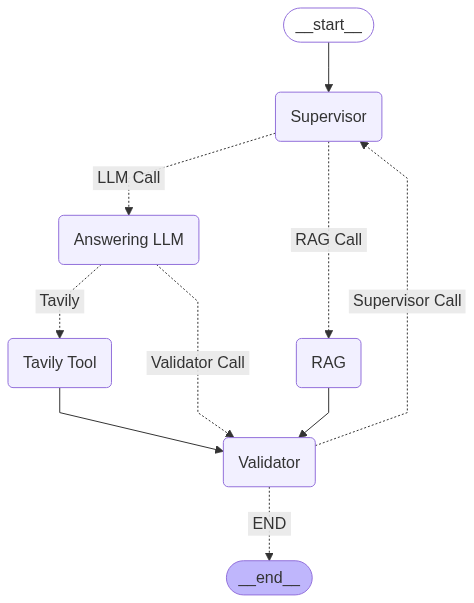

In [518]:
app

In [510]:
app.invoke({"inputs":["Tell me about the stock price of Bajaj?"]})

-> Supervisor Node <-
-> Router 1 <-
-> RAG Call <-
<think>
Okay, so I need to figure out how to respond to the user's query about the stock price of Bajaj using only the context provided. Let me look at the context again. 

The context has three points:

1. The construction cost for a building was ₹8.3 million (US$98,000).
2. The economy of Punjab is the 15th-largest state economy in India with ₹8.
3. Pakistan claimed they downed several Indian jets and damaged infrastructure.

Hmm, none of these points mention anything about Bajaj or its stock price. The first point talks about construction costs, the second about Punjab's economy, and the third about a military incident between India and Pakistan.

I think the user is asking for specific financial data about Bajaj, which isn't covered here. So, I should inform them that the context doesn't provide that information. Maybe I can suggest they look up a financial website or news source for the latest stock prices.
</think>

The context 

{'inputs': ['Tell me about the stock price of Bajaj?',
  True,
  'The query is about the stock price of Bajaj, which is an Indian company.',
  "<think>\nOkay, so I need to figure out how to respond to the user's query about the stock price of Bajaj using only the context provided. Let me look at the context again. \n\nThe context has three points:\n\n1. The construction cost for a building was ₹8.3 million (US$98,000).\n2. The economy of Punjab is the 15th-largest state economy in India with ₹8.\n3. Pakistan claimed they downed several Indian jets and damaged infrastructure.\n\nHmm, none of these points mention anything about Bajaj or its stock price. The first point talks about construction costs, the second about Punjab's economy, and the third about a military incident between India and Pakistan.\n\nI think the user is asking for specific financial data about Bajaj, which isn't covered here. So, I should inform them that the context doesn't provide that information. Maybe I can sugg

In [511]:
app.invoke({"inputs":["Tell me about the aircrash happened on 12 June 2025 in India?"]})

-> Supervisor Node <-
-> Router 1 <-
-> RAG Call <-
<think>
Alright, I need to figure out how to respond to the user's query. They're asking about an airplane crash that happened on June 12, 2025, in India. The context provided is a list of events for 2025 in India, but looking through it, I only see two points about a ceasefire between India and Pakistan on May 10, 2025. There's nothing mentioned about an airplane crash in June.

Hmm, so the context doesn't include any information about an aircrash on that date. The user is probably looking for details about that specific event, but since it's not in the context, I can't provide any information from the given data. I should let them know that there's no information available based on what's provided. Maybe I can suggest checking other sources or waiting for more updates if they need more details.
</think>

Based on the provided context, there is no information available regarding an airplane crash that occurred on June 12, 2025, in In

{'inputs': ['Tell me about the aircrash happened on 12 June 2025 in India?',
  True,
  'The query specifically mentions India as the location of the aircrash, indicating it is related to India.',
  "<think>\nAlright, I need to figure out how to respond to the user's query. They're asking about an airplane crash that happened on June 12, 2025, in India. The context provided is a list of events for 2025 in India, but looking through it, I only see two points about a ceasefire between India and Pakistan on May 10, 2025. There's nothing mentioned about an airplane crash in June.\n\nHmm, so the context doesn't include any information about an aircrash on that date. The user is probably looking for details about that specific event, but since it's not in the context, I can't provide any information from the given data. I should let them know that there's no information available based on what's provided. Maybe I can suggest checking other sources or waiting for more updates if they need more

In [512]:
app.invoke({"inputs":["Tell me about the aircrash happened on 12 June 2025 in India? you may use web search"]})

-> Supervisor Node <-
-> Router 1 <-
-> RAG Call <-
<think>
Okay, so the user is asking about an airplane crash that happened on June 12, 2025, in India. They want me to provide information based only on the context they've given. Let me look at the context provided. 

The context lists events for 2025 in India. It mentions a ceasefire on May 10 after an agreement between India and Pakistan, and India launching missile strikes on Pakistan on May 7 under Operation Sindoor. That's it. There's no mention of any airplane crash, especially not on June 12.

I should make sure I don't add any outside information since the instructions are strict about using only the provided context. So, the answer should clearly state that there's no information about such an event in the context. I should also avoid speculating or suggesting that maybe the user has a different source. Just stick to the facts given.

Maybe the user is confused or has a typo in the date. But regardless, I can't help with that

{'inputs': ['Tell me about the aircrash happened on 12 June 2025 in India? you may use web search',
  True,
  'The query specifically mentions an airplane crash in India, indicating a clear relation to the country.',
  "<think>\nOkay, so the user is asking about an airplane crash that happened on June 12, 2025, in India. They want me to provide information based only on the context they've given. Let me look at the context provided. \n\nThe context lists events for 2025 in India. It mentions a ceasefire on May 10 after an agreement between India and Pakistan, and India launching missile strikes on Pakistan on May 7 under Operation Sindoor. That's it. There's no mention of any airplane crash, especially not on June 12.\n\nI should make sure I don't add any outside information since the instructions are strict about using only the provided context. So, the answer should clearly state that there's no information about such an event in the context. I should also avoid speculating or sugges

In [513]:
app.invoke({"inputs":["Tell me about the aircrash happened on 12 June 2025 in India? If you dont have any context use tavily"]})

-> Supervisor Node <-
-> Router 1 <-
-> RAG Call <-
<think>
Okay, so the user is asking about an airplane crash that happened on June 12, 2025, in India. Let me check the context provided. The context is a list of events for 2025 in India, and it only mentions two things: the launch of missile strikes on Pakistan on May 7, 2025, as part of Operation Sindoor, and the 2025 India-Pakistan conflict that started on the same date. There's no mention of any airplane crash on June 12 or any other date. 

Hmm, so based on the context given, I don't have any information about an aircrash on that specific date. The user also mentioned that if I don't have any context, I should use "tavily context," but I think that might be a typo. Maybe they meant "use the provided context." Since the context doesn't include the crash, I should inform the user that there's no information available about that event in the given context.

I should make sure to respond clearly, letting them know that the crash isn'

{'inputs': ['Tell me about the aircrash happened on 12 June 2025 in India? If you dont have any context use tavily',
  True,
  'The query specifically mentions an event in India, indicating it is related to the country.',
  '<think>\nOkay, so the user is asking about an airplane crash that happened on June 12, 2025, in India. Let me check the context provided. The context is a list of events for 2025 in India, and it only mentions two things: the launch of missile strikes on Pakistan on May 7, 2025, as part of Operation Sindoor, and the 2025 India-Pakistan conflict that started on the same date. There\'s no mention of any airplane crash on June 12 or any other date. \n\nHmm, so based on the context given, I don\'t have any information about an aircrash on that specific date. The user also mentioned that if I don\'t have any context, I should use "tavily context," but I think that might be a typo. Maybe they meant "use the provided context." Since the context doesn\'t include the crash,

In [520]:
app.invoke({"inputs":["Tell me the GDP of India in 2024"]})

-> Supervisor Node <-
-> Router 1 <-
-> RAG Call <-
<think>
Okay, so the user is asking for the GDP of India in 2024. I need to look at the provided context to find the answer. Let me read through the context again.

The context mentions two points: first, that India's gross domestic savings rate was 29.3% of GDP in 2022, and second, that the most recent election was in 2024. There's no direct information about the GDP value for 2024 here. 

Hmm, the user is specifically asking for GDP in 2024, but the context only gives the savings rate for 2022 and an election year. I don't see any GDP figures for 2024. Maybe they're confusing the election year with economic data, but I can't assume that. 

I should make sure not to provide incorrect information. The best response is to state that the context doesn't include the GDP for 2024 and suggest looking for more recent or specific data sources. That way, the user knows where to find the information they're seeking without getting misleading a

{'inputs': ['Tell me the GDP of India in 2024',
  True,
  'The query asks for the GDP of India in 2024, which is directly related to India.',
  "<think>\nOkay, so the user is asking for the GDP of India in 2024. I need to look at the provided context to find the answer. Let me read through the context again.\n\nThe context mentions two points: first, that India's gross domestic savings rate was 29.3% of GDP in 2022, and second, that the most recent election was in 2024. There's no direct information about the GDP value for 2024 here. \n\nHmm, the user is specifically asking for GDP in 2024, but the context only gives the savings rate for 2022 and an election year. I don't see any GDP figures for 2024. Maybe they're confusing the election year with economic data, but I can't assume that. \n\nI should make sure not to provide incorrect information. The best response is to state that the context doesn't include the GDP for 2024 and suggest looking for more recent or specific data sources.

In [522]:
app.invoke({"inputs":["Who won the loksabha elections of India in 2019?"]})

-> Supervisor Node <-
-> Router 1 <-
-> RAG Call <-
<think>
Alright, let me try to figure out how to answer the user's query. The user is asking, "Who won the Lok Sabha elections of India in 2019?" and they've provided some context. My first step is to look at the context they've given to see if it contains the answer.

Looking at the context, I see that it starts with a list of events for the year 2025 in India. The first point mentions the fourth meeting held in New Delhi on 19 December. Then, the next line describes India as a country in South Asia. There's no mention of the 2019 Lok Sabha elections here.

Since the context is about 2025 events and general information about India, it doesn't cover the 2019 elections. I know from my general knowledge that the 2019 Lok Sabha elections were won by the Bharatiya Janata Party (BJP) led by Narendra Modi, but I can't use that information because I must strictly adhere to the provided context.

So, the answer must be based solely on the con

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [526]:
app.invoke({"inputs":["What is the crude oil price today?"]})

-> Supervisor Node <-
-> Router 1 <-
-> Answering LLM Call <-
-> Router 2 <-
-> Tavily Tool Call <-
-> Validator Call <-


{'inputs': ['What is the crude oil price today?',
  False,
  'The query does not mention India or any related terms.',
  False,
  "I'm unable to provide real-time crude oil prices. However, I can offer historical data or general information about crude oil pricing if that's helpful.",
  'As of June 12, 2025, crude oil prices have fallen by 2% due to market concerns over the Israel-Iran conflict. The current WTI crude oil price is $64.58 per barrel. Brent crude oil is priced at $66.47 per barrel.',
  True,
  'As of June 12, 2025, crude oil prices have fallen by 2% due to market concerns over the Israel-Iran conflict. The current WTI crude oil price is $64.58 per barrel. Brent crude oil is priced at $66.47 per barrel.']}